# Arrow
Vaex supports [Arrow](https://arrow.apache.org). We will demonstrate vaex+arrow by giving a quick look at a large dataset that does not fit into memory. The NYC taxi dataset for the year 2015 contains about 150 million rows containing information about taxi trips in New York, and is about 23GB in size. You can download it here:
 
 * https://docs.vaex.io/en/latest/datasets.html

In case you want to convert it to the arrow format, use the code below:
```python
ds_hdf5 = vaex.open('/Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.hdf5')
# this may take a while to export
ds_hdf5.export('./nyc_taxi2015.arrow')
```
Also make sure you install vaex-arrow:
```bash
$ pip install vaex-arrow
```

In [1]:
!ls -alh /Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow

-rw-r--r--  1 maartenbreddels  staff    23G Oct 31 18:56 /Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow


In [3]:
import vaex

## Opens instantly
Opening the file goes instantly, since nothing is being copied to memory. The data is only memory mapped, a technique that will only read the data when needed.

In [4]:
%time
df = vaex.open('/Users/maartenbreddels/datasets/nytaxi/nyc_taxi2015.arrow')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [5]:
df

## Quick viz of 146 million rows
As can be seen, this dataset contains 146 million rows.
Using plot, we can generate a quick overview what the data contains. The pickup locations nicely outline Manhattan.

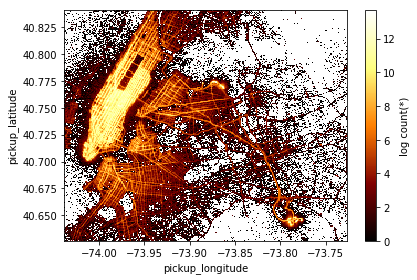

In [6]:
df.plot(df.pickup_longitude, df.pickup_latitude, f='log');

In [7]:
df.total_amount.minmax()

array([-4.9630000e+02,  3.9506116e+06])

## Data cleansing: outliers
As can be seen from the total_amount columns (how much people payed), this dataset contains outliers. From a quick 1d plot, we can see reasonable ways to filter the data

In [8]:
df.plot1d(df.total_amount, shape=100, limits=[0, 100])

In [9]:
# filter the dataset
dff = df[(df.total_amount >= 0) & (df.total_amount < 100)]

## Shallow copies
This filtered dataset did not copy any data (otherwise it would have costed us about ~23GB of RAM). Shallow copies of the data are made instead and a booleans mask tracks which rows should be used.

In [10]:
dff['ratio'] = dff.tip_amount/dff.total_amount

## Virtual column
The new column `ratio` does not do any computation yet, it only stored the expression and does not waste any memory. However, the new (virtual) column can be used in calculations as if it were a normal column.

In [11]:
dff.ratio.mean()

<string>:1: RuntimeWarning: invalid value encountered in true_divide


0.09601926650107262

## Result
Our final result, the percentage of the tip, can be easily calcualted for this large dataset, it did not require any excessive amount of memory.

## Interoperability
Since the data lives as Arrow arrays, we can pass them around to other libraries such as pandas, or even pass it to other processes.

In [12]:
arrow_table = df.to_arrow_table()
arrow_table

pyarrow.Table
VendorID: int64
dropoff_dayofweek: double
dropoff_hour: double
dropoff_latitude: double
dropoff_longitude: double
extra: double
fare_amount: double
improvement_surcharge: double
mta_tax: double
passenger_count: int64
payment_type: int64
pickup_dayofweek: double
pickup_hour: double
pickup_latitude: double
pickup_longitude: double
tip_amount: double
tolls_amount: double
total_amount: double
tpep_dropoff_datetime: timestamp[ns]
tpep_pickup_datetime: timestamp[ns]
trip_distance: double

In [13]:
# Although you can 'convert' (pass the data) in to pandas,
# some memory will be wasted (at least an index will be created by pandas)
# here we just pass a subset of the data
df_pandas = df[:10000].to_pandas_df()
df_pandas

VendorID  dropoff_dayofweek  dropoff_hour  dropoff_latitude  \
0            2                3.0          19.0         40.750618   
1            1                5.0          20.0         40.759109   
2            1                5.0          20.0         40.824413   
3            1                5.0          20.0         40.719986   
4            1                5.0          20.0         40.742653   
5            1                5.0          20.0         40.758194   
6            1                5.0          20.0         40.749634   
7            1                5.0          20.0         40.726326   
8            1                5.0          21.0         40.759357   
9            1                5.0          20.0         40.759365   
10           1                5.0          20.0         40.728584   
11           1                5.0          20.0         40.757217   
12           1                5.0          20.0         40.707726   
13           1                5.0          21.0         40.735210   
14           1                5.0          20.0         40.739895   
15           2                3.0          19.0         40.757889   
16           2                3.0          19.0         40.786858   
17           2                3.0          19.0         40.785782   
18           2                3.0          19.0         40.786083   
19           2                3.0          19.0         40.718590   
20           2                3.0          19.0         40.714596   
21           2                3.0          19.0         40.734650   
22           2                3.0          19.0         40.735512   
23           2                3.0          19.0         40.704220   
24           2                3.0          19.0         40.761856   
25           2                3.0          19.0         40.811089   
26           2                3.0          19.0         40.734890   
27           2                3.0          19.0         40.743530   
28           2                3.0          19.0         40.757721   
29           2                3.0          19.0         40.704689   
...        ...                ...           ...               ...   
9970         1                4.0          11.0         40.719917   
9971         1                4.0          10.0         40.720398   
9972         1                4.0          11.0         40.755405   
9973         2                1.0          19.0         40.763626   
9974         2                1.0          19.0         40.772366   
9975         2                1.0          19.0         40.733429   
9976         2                1.0          19.0         40.774780   
9977         2                1.0          19.0         40.751698   
9978         2                1.0          19.0         40.752941   
9979         2                1.0          19.0         40.735130   
9980         2                1.0          19.0         40.745541   
9981         2                1.0          19.0         40.793671   
9982         2                1.0          19.0         40.754639   
9983         2                1.0          18.0         40.723721   
9984         2                1.0          19.0         40.774590   
9985         2                1.0          19.0         40.774872   
9986         2                1.0          19.0         40.787998   
9987         2                1.0          19.0         40.790218   
9988         2                1.0          19.0         40.739487   
9989         2                1.0          19.0         40.780548   
9990         2                1.0          19.0         40.761524   
9991         2                1.0          19.0         40.720646   
9992         2                1.0          19.0         40.795898   
9993         2                1.0          18.0         40.769939   
9994         2                4.0          18.0         40.773521   
9995         2                4.0          18.0         40.774670   
9996

## Tutorial
If you want to learn more on vaex, take a look at the [tutorials to see what is possible](https://docs.vaex.io/en/latest/tutorial.html).